In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df=pd.read_csv('/content/drive/MyDrive/DS360 Machine Learning/Course DSML/ML/Time Series Analysis/PJME_hourly.csv', index_col=[0], parse_dates=[0])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.shape

(145366, 1)

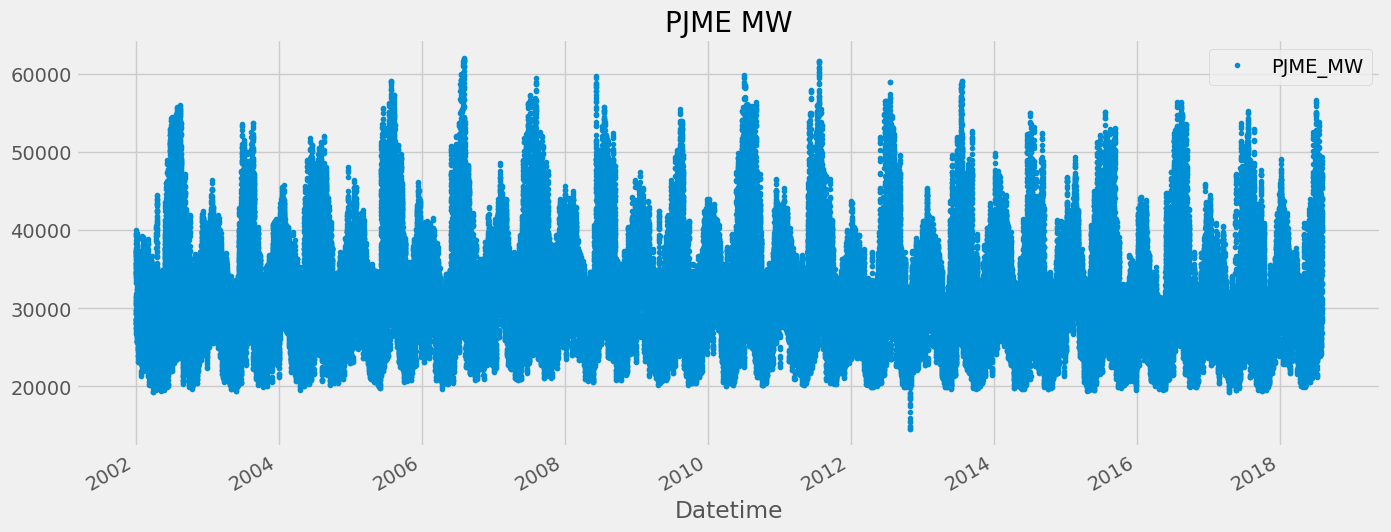

In [5]:
df.plot(style='.', figsize=(15, 6), title='PJME MW');

In [6]:
from pandas.api.types import CategoricalDtype
import pandas as pd

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday',
                                        'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_features(data, label=None):
    """
    Creates time series features from datetime index.
    """
    df = data.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    # Replace deprecated 'weekofyear' with isocalendar().week
    df['weekofyear'] = df['date'].dt.isocalendar().week

    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]

    if label:
        y = df[label]
        return X, y
    return X

# Example usage with a DataFrame `pjme` and a label column 'PJME_MW'
X, y = create_features(df, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [7]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter


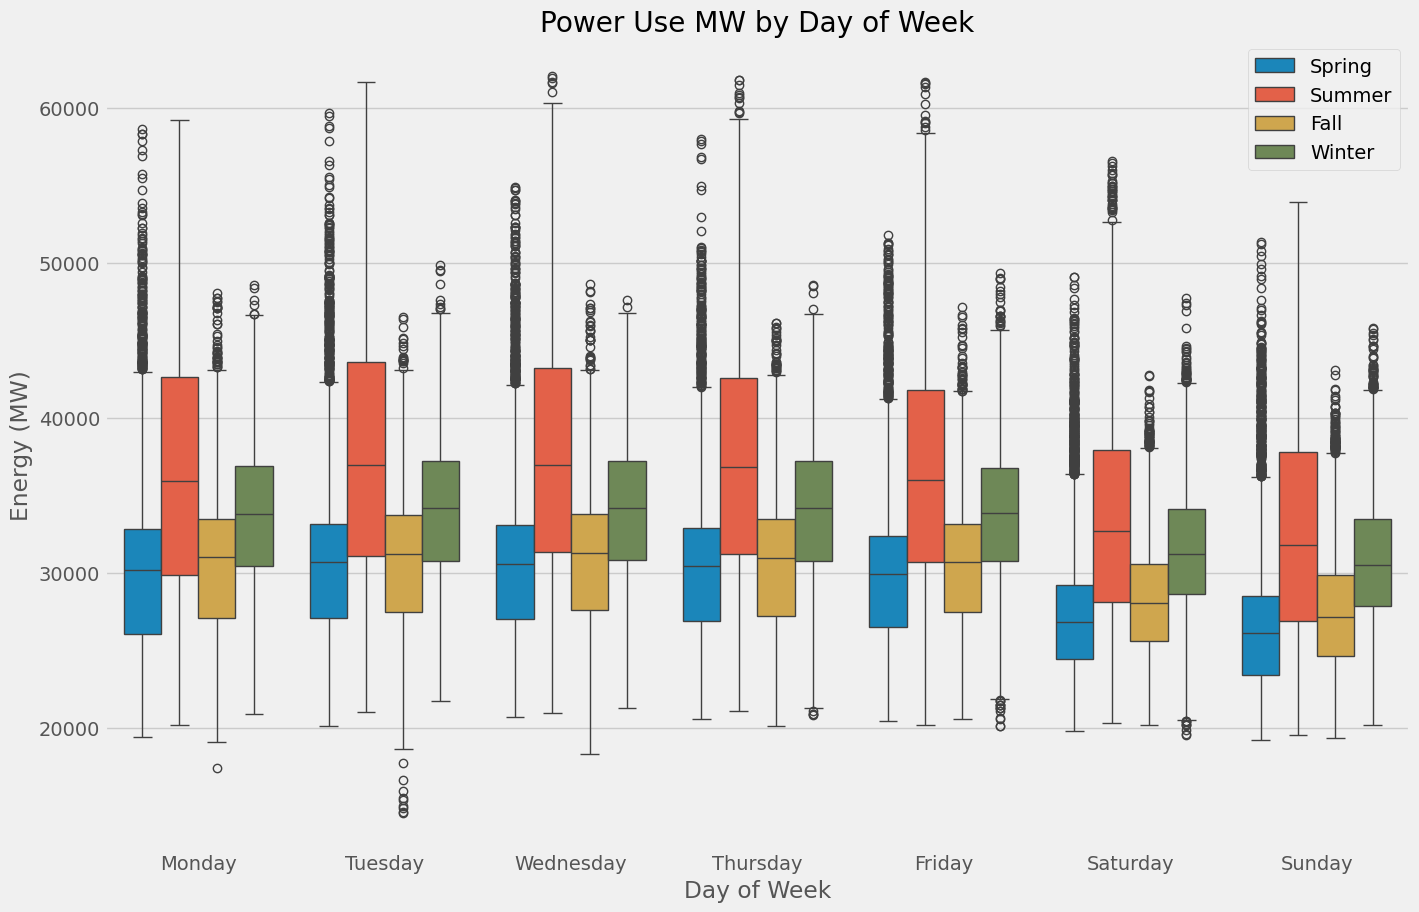

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

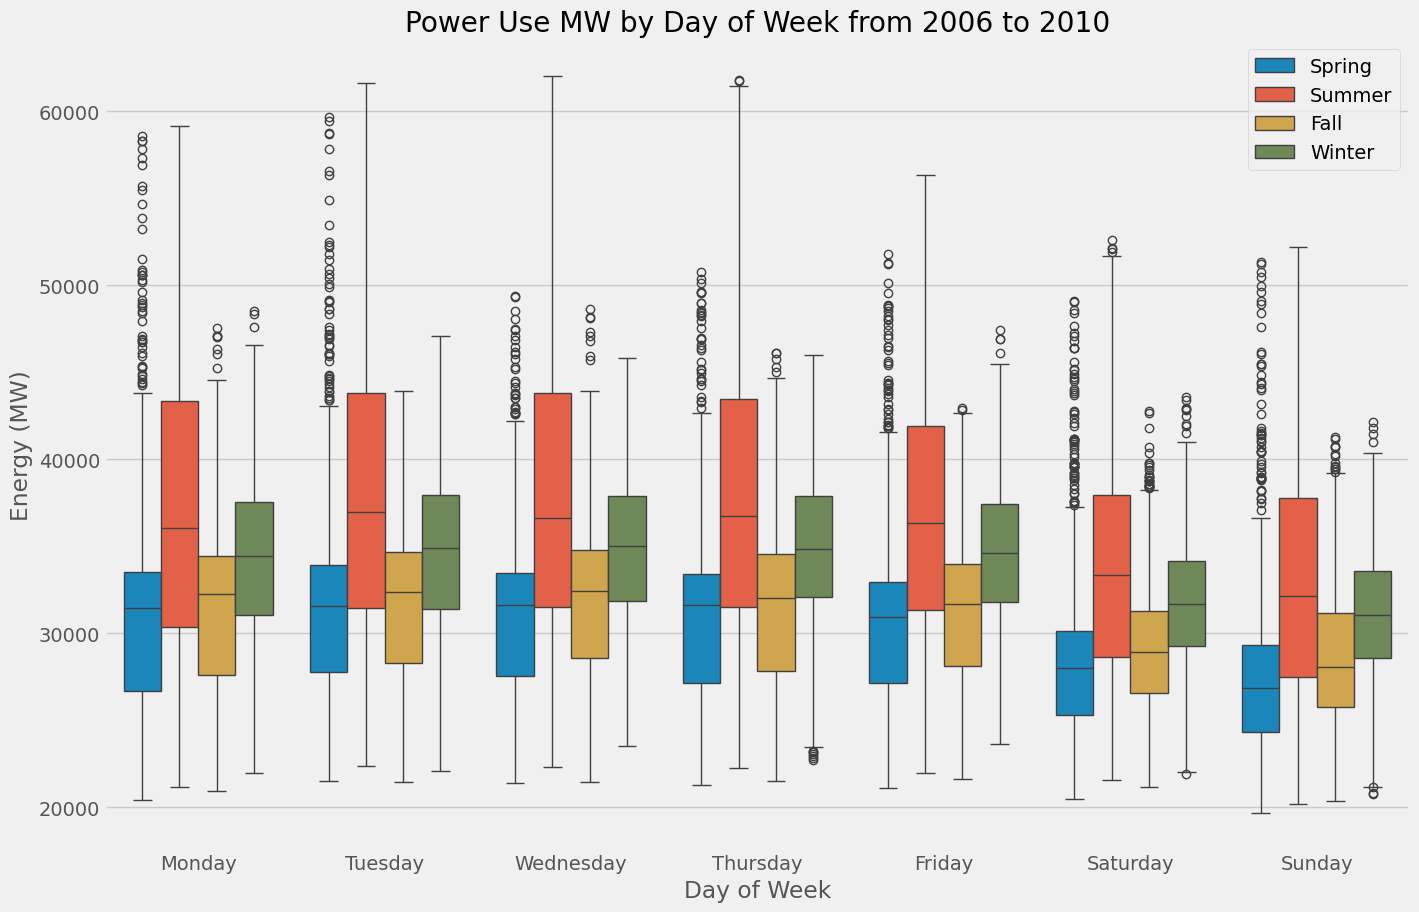

In [9]:
features_and_target_2=features_and_target.loc[(features_and_target.index >= '2006-01-01') & (features_and_target.index < '2010-01-01')]

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(data=features_and_target_2.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week from 2006 to 2010')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

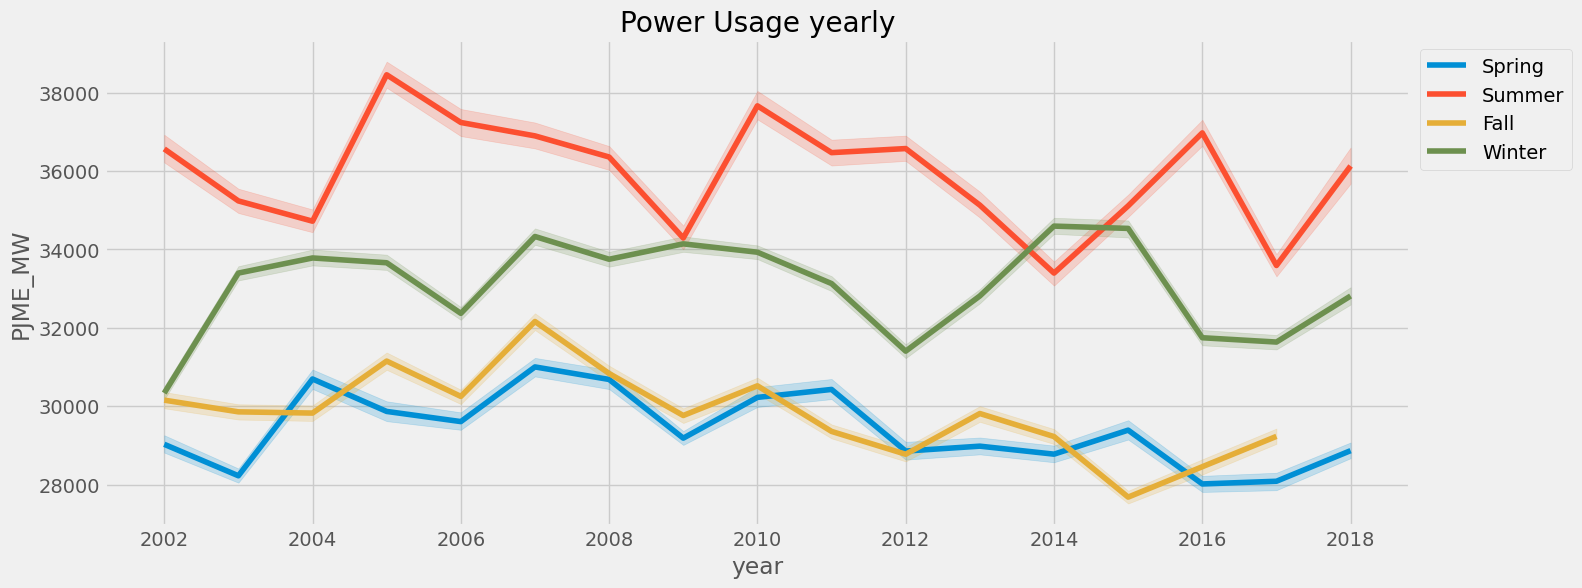

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=features_and_target.dropna(), x='year', y='PJME_MW', hue='season')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Power Usage yearly')
plt.show()

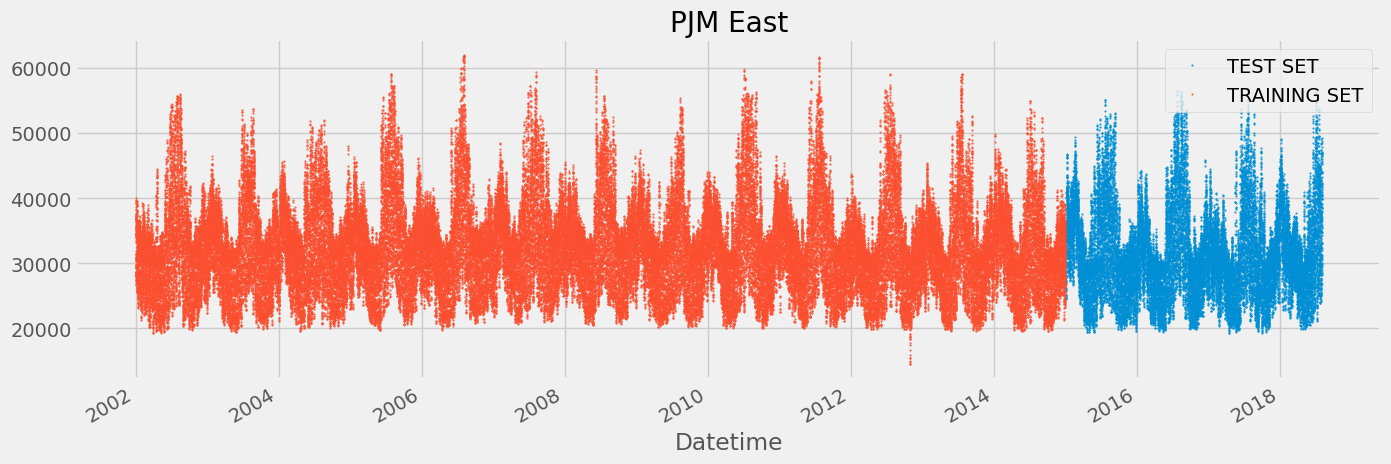

In [11]:
train = df.loc[df.index <= '1-Jan-2015'].copy()
test = df.loc[df.index > '1-Jan-2015'].copy()

test.rename(columns={'PJME_MW': 'TEST SET'}).join(train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer')\
            .plot(figsize=(15, 5), title='PJM East', style='.', ms=1)
plt.show()

In [12]:
train

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2014-01-01 20:00:00,36193.0
2014-01-01 21:00:00,35601.0
2014-01-01 22:00:00,34242.0


In [13]:
test

,PJME_MW
Datetime,
2015-12-31 01:00:00,24305.0
2015-12-31 02:00:00,23156.0
2015-12-31 03:00:00,22514.0
2015-12-31 04:00:00,22330.0
2015-12-31 05:00:00,22773.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [14]:
train_set=train.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})
test_set=test.reset_index().rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})

In [15]:
train_set.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [16]:
test_set.head()

,ds,y
0,2015-12-31 01:00:00,24305.0
1,2015-12-31 02:00:00,23156.0
2,2015-12-31 03:00:00,22514.0
3,2015-12-31 04:00:00,22330.0
4,2015-12-31 05:00:00,22773.0


In [17]:
model=Prophet(weekly_seasonality=True, daily_seasonality=True)
model.fit(train_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp0vf_07_/llhi9q48.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp0vf_07_/yx597laq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42853', 'data', 'file=/tmp/tmpp0vf_07_/llhi9q48.json', 'init=/tmp/tmpp0vf_07_/yx597laq.json', 'output', 'file=/tmp/tmpp0vf_07_/prophet_modelrvhfmkig/prophet_model-20241121155955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [18]:
forecast=model.predict(test_set)
type(forecast)

pandas.core.frame.DataFrame

In [19]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,23583.401752,33061.838309,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22294.587614,31322.999312,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21620.747966,30432.476897,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21612.380494,30334.125787,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21665.010731,30809.760885,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


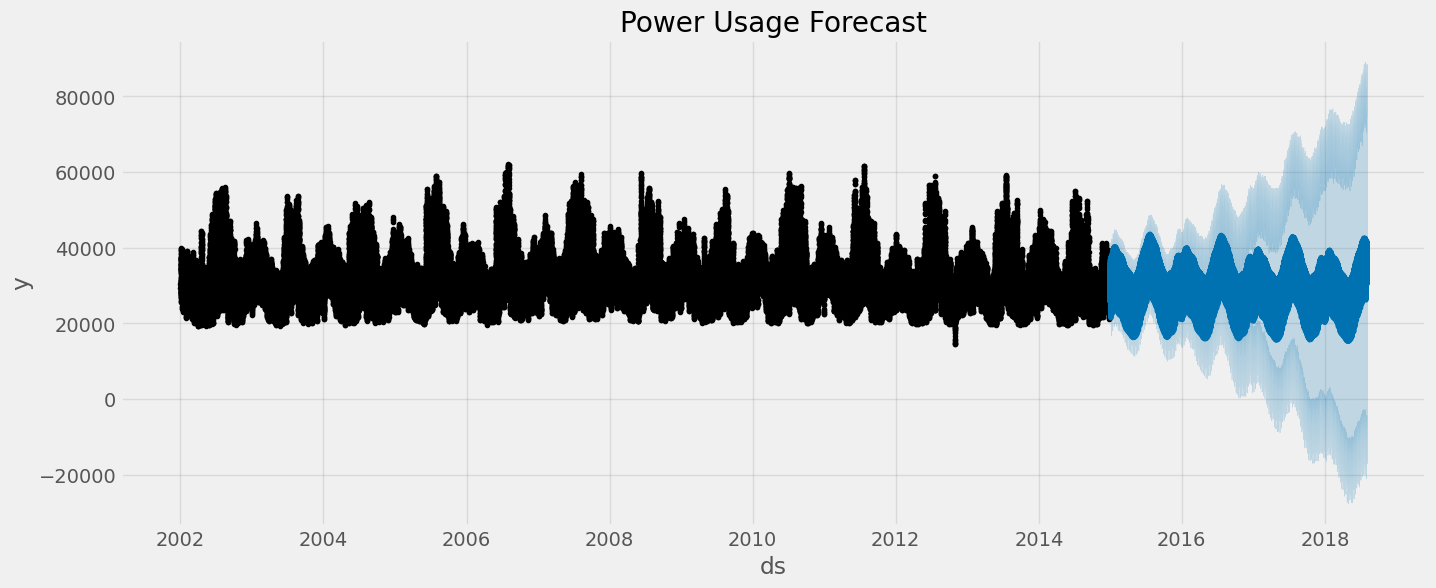

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
fig=model.plot(forecast, ax=ax)
ax.set_title('Power Usage Forecast')
plt.show()

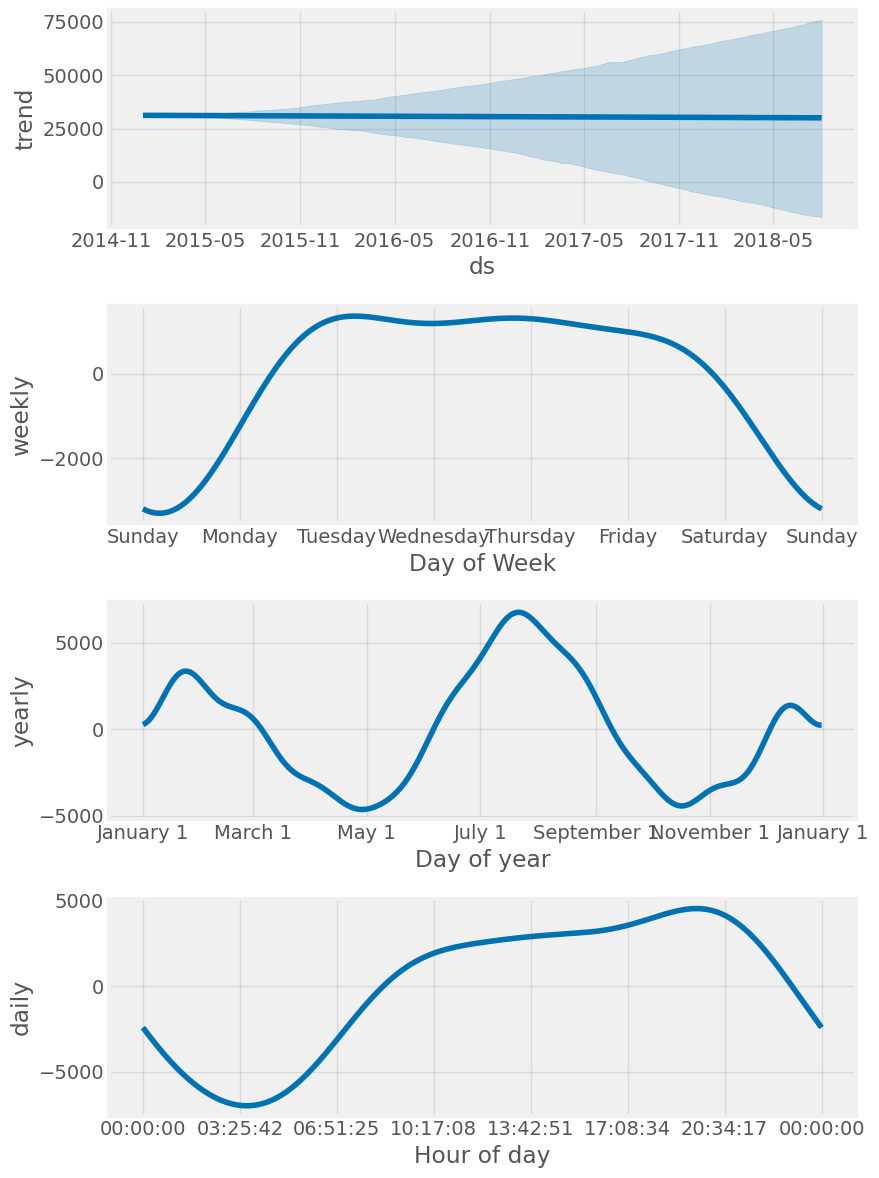

In [21]:
fig=model.plot_components(forecast)
plt.show()

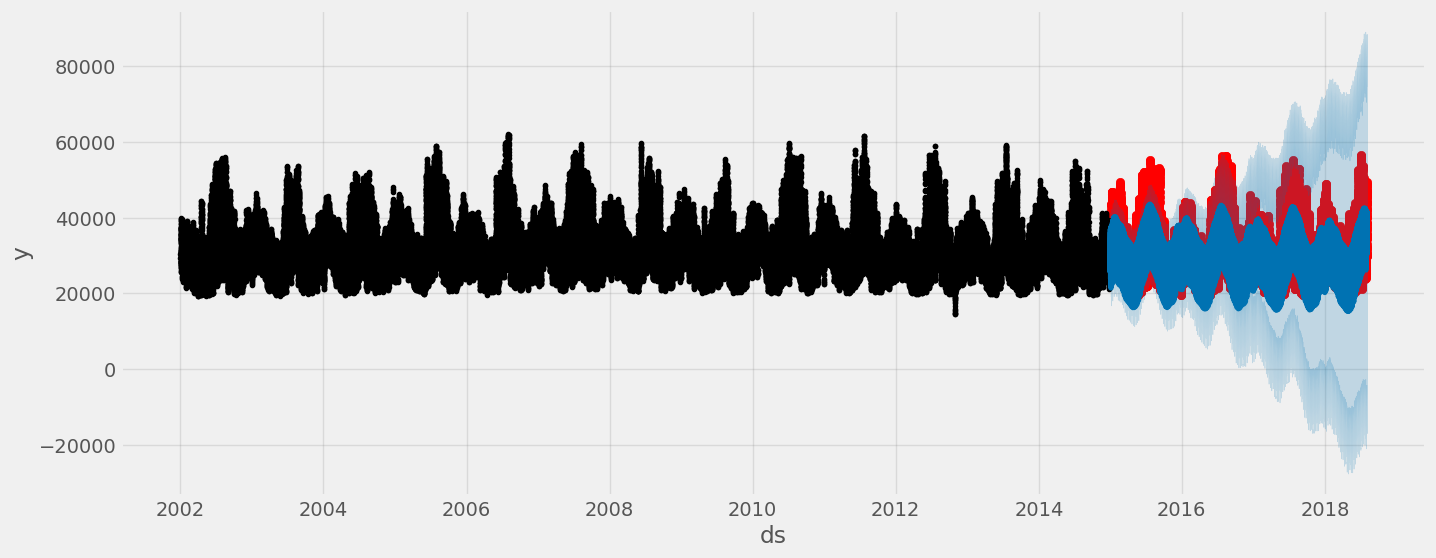

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(test.index, test['PJME_MW'], color='r')
fig = model.plot(forecast, ax=ax)

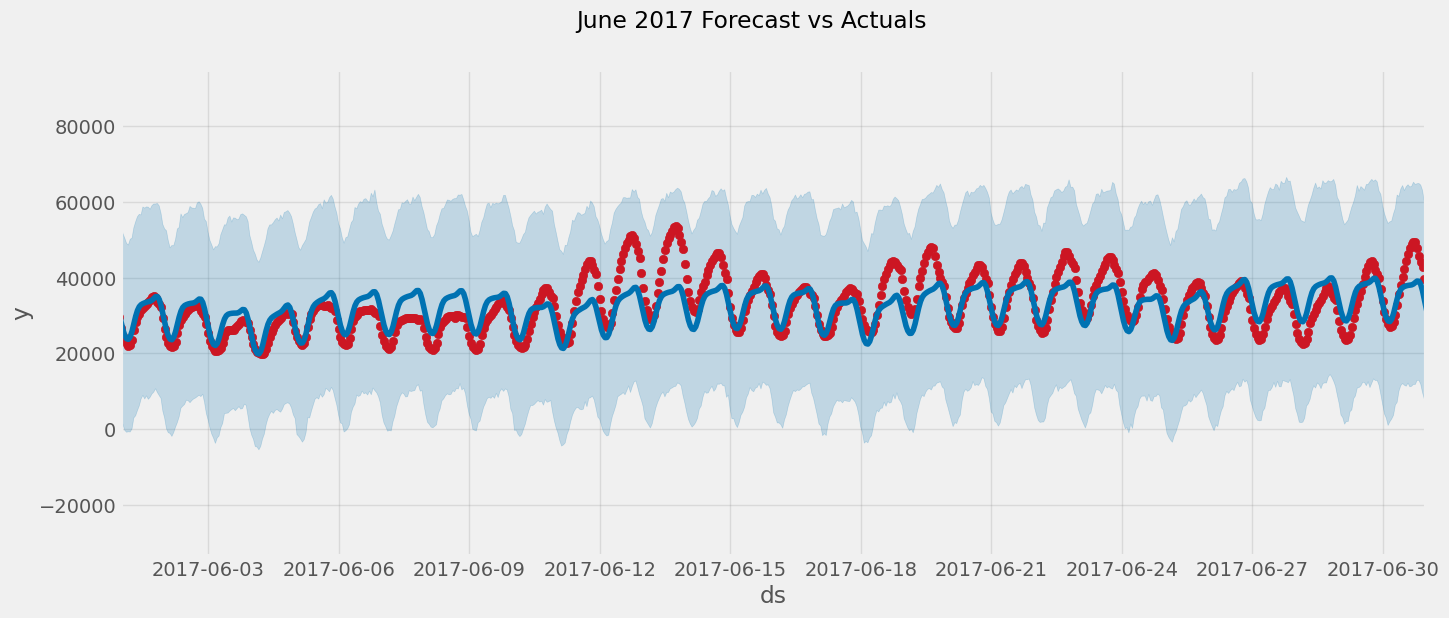

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(test.index, test['PJME_MW'], color='r')

fig = model.plot(forecast, ax=ax)

ax.set_xbound(upper=pd.Timestamp('2017-06-01'), lower=pd.Timestamp('2017-07-01'))

plot = plt.suptitle('June 2017 Forecast vs Actuals')

plt.show()

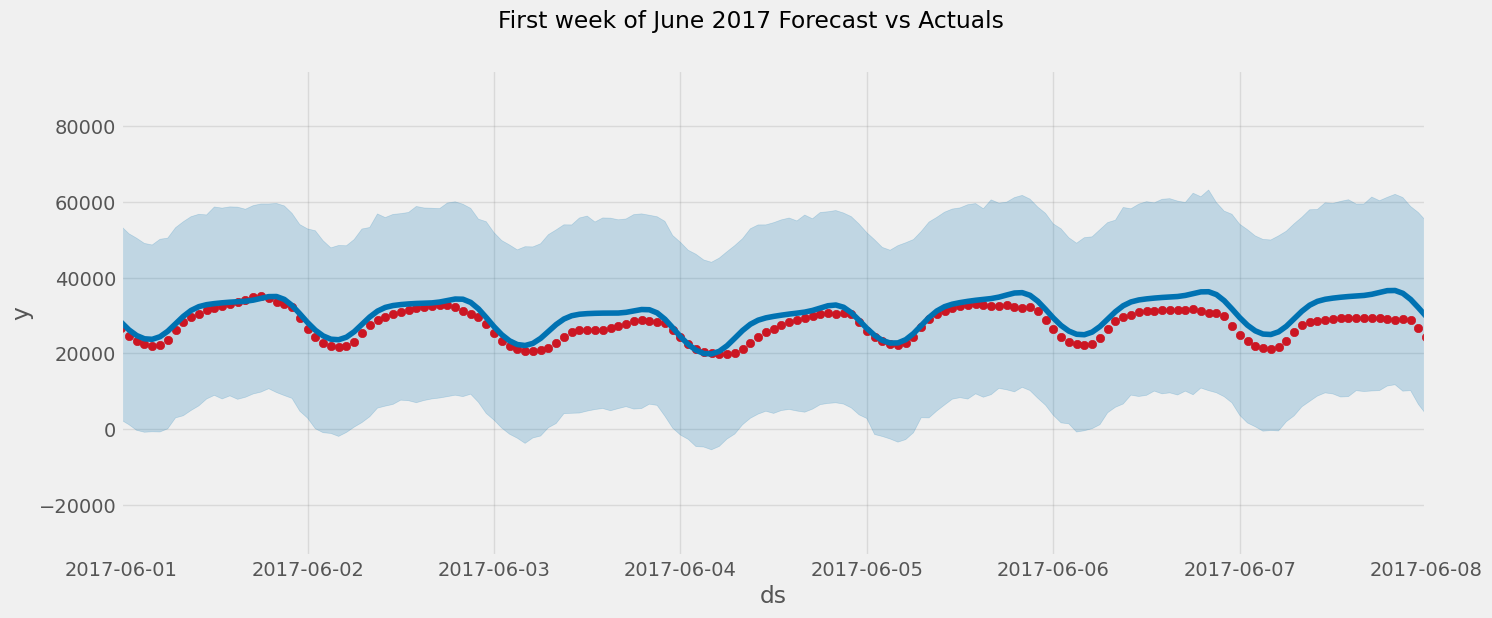

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(test.index, test['PJME_MW'], color='r')

fig = model.plot(forecast, ax=ax)

ax.set_xbound(upper=pd.Timestamp('2017-06-01'), lower=pd.Timestamp('2017-06-08'))

plot = plt.suptitle('First week of June 2017 Forecast vs Actuals')

plt.show()

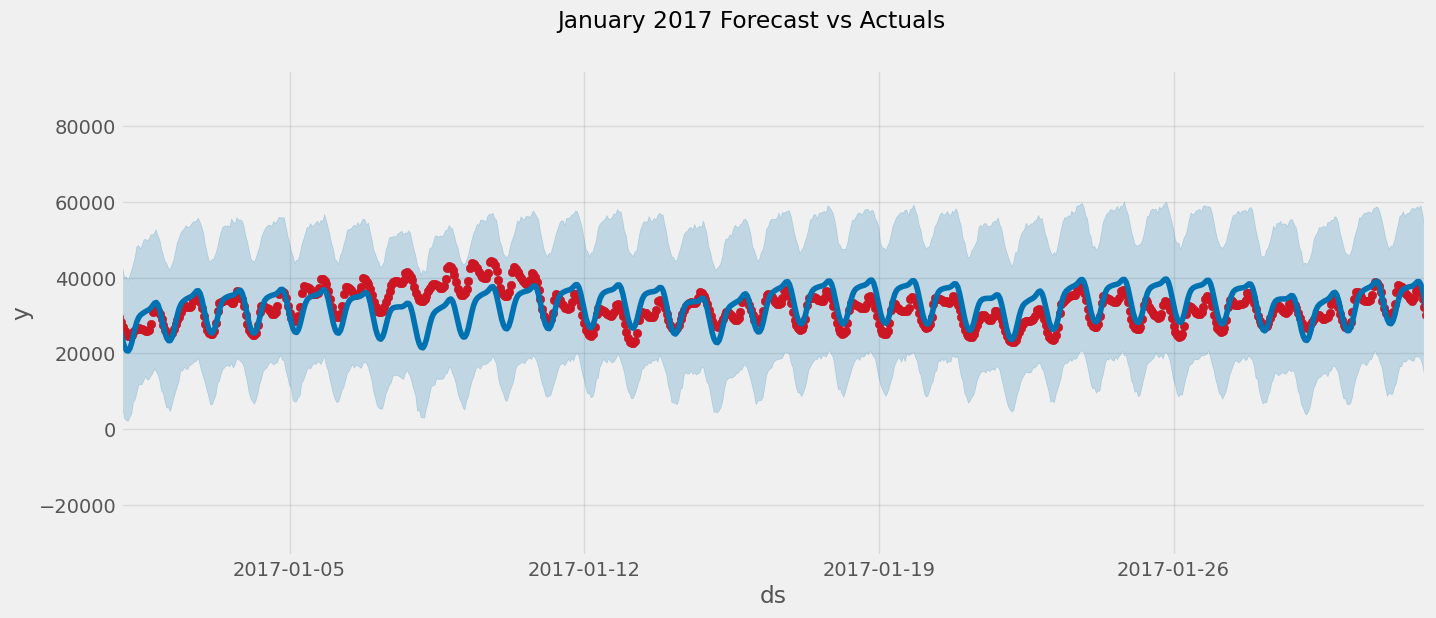

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(test.index, test['PJME_MW'], color='r')

fig = model.plot(forecast, ax=ax)

ax.set_xbound(upper=pd.Timestamp('2017-01-01'), lower=pd.Timestamp('2017-02-01'))

plot = plt.suptitle('January 2017 Forecast vs Actuals')

plt.show()

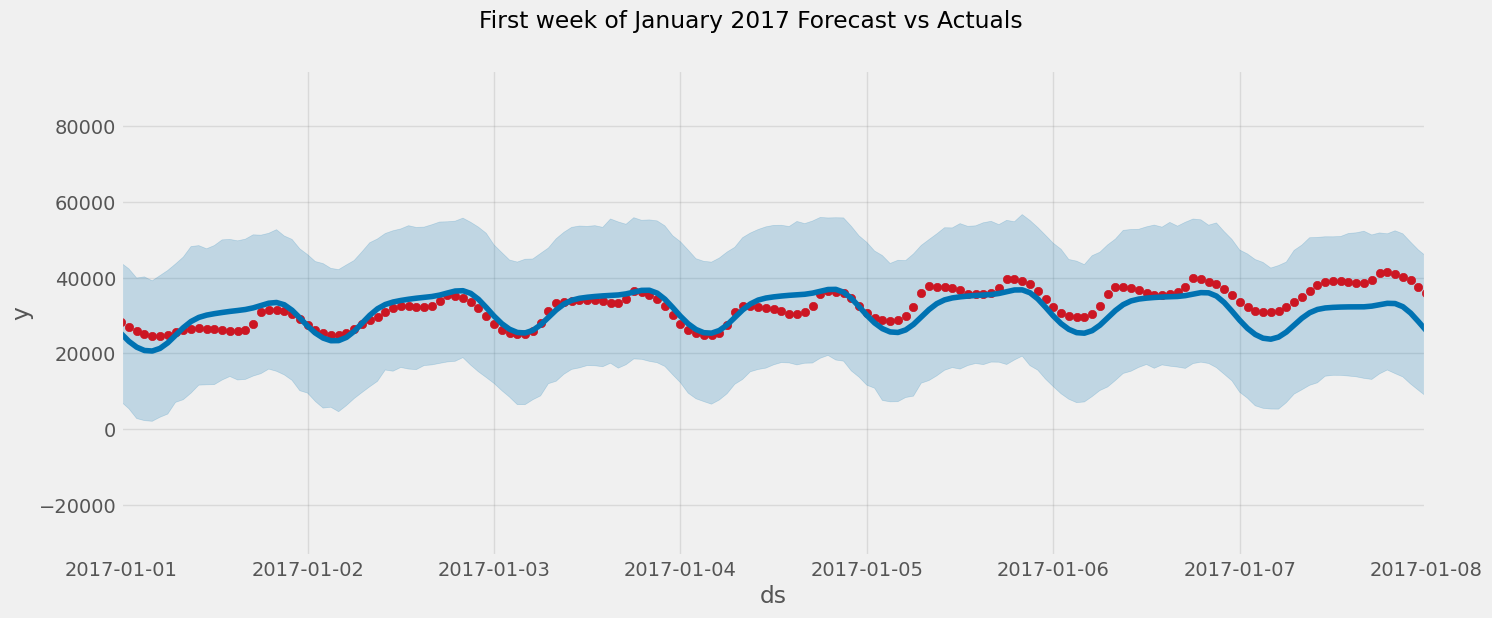

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.scatter(test.index, test['PJME_MW'], color='r')

fig = model.plot(forecast, ax=ax)

ax.set_xbound(upper=pd.Timestamp('2017-01-01'), lower=pd.Timestamp('2017-01-08'))

plot = plt.suptitle('First week of January 2017 Forecast vs Actuals')

plt.show()

In [27]:
mean_squared_error(test['PJME_MW'], forecast['yhat'])

43784240.02744754

In [28]:
np.sqrt(mean_squared_error(test['PJME_MW'], forecast['yhat']))

6616.966074225221

In [29]:
mean_absolute_error(test['PJME_MW'], forecast['yhat'])

5181.911537928106

In [30]:
np.sqrt(mean_absolute_error(test['PJME_MW'], forecast['yhat']))

71.98549533015735

In [31]:
mean_absolute_percentage_error(test['PJME_MW'], forecast['yhat'])

16.512003880182647

In [32]:
future=model.make_future_dataframe(periods=4000*24, freq='h', include_history=False)
future_forecast=model.predict(future)

In [33]:
future.head()

,ds
0,2015-01-01 01:00:00
1,2015-01-01 02:00:00
2,2015-01-01 03:00:00
3,2015-01-01 04:00:00
4,2015-01-01 05:00:00


In [34]:
future.tail()

,ds
95995,2025-12-13 20:00:00
95996,2025-12-13 21:00:00
95997,2025-12-13 22:00:00
95998,2025-12-13 23:00:00
95999,2025-12-14 00:00:00


In [35]:
future_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,24013.489792,32707.599631,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,21917.086917,31434.088886,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21268.797387,30272.698476,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21444.280802,30806.285992,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,21932.531565,30811.546084,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,2025-12-13 20:00:00,27676.693418,-193162.189768,270361.859926,-195704.478193,268287.101929,2927.013466,2927.013466,2927.013466,4450.909992,...,-2904.813023,-2904.813023,-2904.813023,1380.916497,1380.916497,1380.916497,0.0,0.0,0.0,30603.706885
95996,2025-12-13 21:00:00,27676.656606,-193812.164631,270889.032876,-195710.854943,268290.716638,2086.533481,2086.533481,2086.533481,3695.764461,...,-2990.560477,-2990.560477,-2990.560477,1381.329498,1381.329498,1381.329498,0.0,0.0,0.0,29763.190087
95997,2025-12-13 22:00:00,27676.619793,-196478.675284,271710.617298,-195717.231692,268294.331347,399.584205,399.584205,399.584205,2084.421752,...,-3066.538395,-3066.538395,-3066.538395,1381.700849,1381.700849,1381.700849,0.0,0.0,0.0,28076.203998
95998,2025-12-13 23:00:00,27676.582980,-198033.937243,265080.162442,-195723.608441,268297.946056,-1855.233891,-1855.233891,-1855.233891,-105.112315,...,-3132.152207,-3132.152207,-3132.152207,1382.030631,1382.030631,1382.030631,0.0,0.0,0.0,25821.349089


In [36]:
future_forecast=future_forecast[['ds', 'yhat']]

In [37]:
future_forecast.set_index('ds', inplace=True)
future_forecast

,yhat
ds,
2015-01-01 01:00:00,28316.788495
2015-01-01 02:00:00,26812.254729
2015-01-01 03:00:00,25940.482857
2015-01-01 04:00:00,25798.964119
2015-01-01 05:00:00,26473.365610
...,...
2025-12-13 20:00:00,30603.706885
2025-12-13 21:00:00,29763.190087
2025-12-13 22:00:00,28076.203998


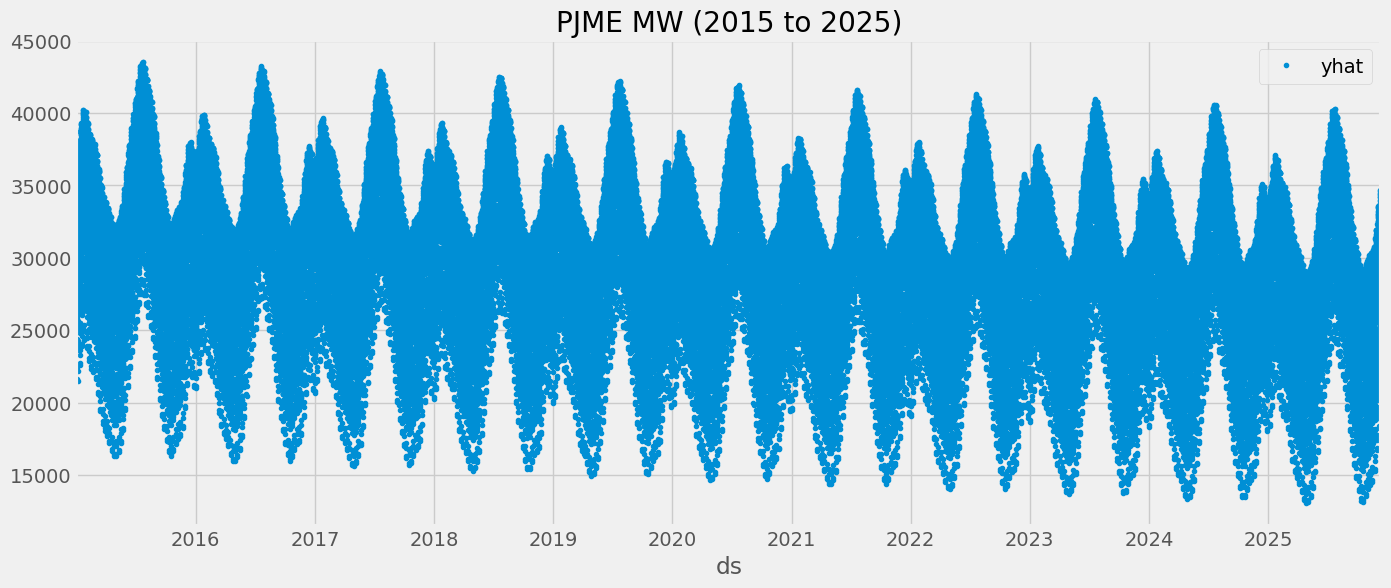

In [38]:
future_forecast.plot(style='.', figsize=(15, 6), title='PJME MW (2015 to 2025)');